In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spellchecker import SpellChecker
#import pyspark

# nltk packages
from string import punctuation
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import RegexpTokenizer

In [6]:
# Read Train Data
col_names = ['sentiment', 'title', 'text']
df = pd.read_csv('../data/train.csv', names=col_names)                

# Data Understanding

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   sentiment  int64 
 1   title      object
 2   text       object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB


In [8]:
df.head()

,sentiment,title,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [9]:
df.describe()

,sentiment
count,3600000.0
mean,1.5
std,0.5
min,1.0
25%,1.0
50%,1.5
75%,2.0
max,2.0


In [10]:
# Check for NaNs
df.isna().sum()

sentiment     0
title        77
text          0
dtype: int64

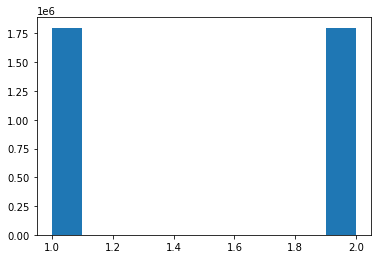

In [11]:
plt.hist(df['sentiment']);

In [14]:
df['text'][0].strip()

'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

# Data Preprocessing

In [96]:
# Define a list of stop words/punctuation to be ommited during tokenization

stop_list = stopwords.words("english") 
#+ list(punctuation)
regex_pattern = "([a-zA-Z]+(?:'[a-z]+)?)"



In [103]:
tokenizer = RegexpTokenizer(regex_pattern)
tokenizer.tokenize(df['text'][0])

['This',
 'sound',
 'track',
 'was',
 'beautiful',
 'It',
 'paints',
 'the',
 'senery',
 'in',
 'your',
 'mind',
 'so',
 'well',
 'I',
 'would',
 'recomend',
 'it',
 'even',
 'to',
 'people',
 'who',
 'hate',
 'vid',
 'game',
 'music',
 'I',
 'have',
 'played',
 'the',
 'game',
 'Chrono',
 'Cross',
 'but',
 'out',
 'of',
 'all',
 'of',
 'the',
 'games',
 'I',
 'have',
 'ever',
 'played',
 'it',
 'has',
 'the',
 'best',
 'music',
 'It',
 'backs',
 'away',
 'from',
 'crude',
 'keyboarding',
 'and',
 'takes',
 'a',
 'fresher',
 'step',
 'with',
 'grate',
 'guitars',
 'and',
 'soulful',
 'orchestras',
 'It',
 'would',
 'impress',
 'anyone',
 'who',
 'cares',
 'to',
 'listen']

In [121]:
def prepare_data(text, sw=stop_list):
    """
    Standardize case, tokenize, remove punctuation and lemmatize text from a row
    of a dataframe.
    """
   
    tokenizer = RegexpTokenizer(regex_pattern)
    tokens = tokenizer.tokenize(text)
    tokens_nosw = [token.lower() for token in tokens if token.lower() not in sw]
    return tokens_nosw

In [122]:
sample_row = prepare_data(df['text'][0])

In [123]:
sample_row

['sound',
 'track',
 'beautiful',
 'paints',
 'senery',
 'mind',
 'well',
 'would',
 'recomend',
 'even',
 'people',
 'hate',
 'vid',
 'game',
 'music',
 'played',
 'game',
 'chrono',
 'cross',
 'games',
 'ever',
 'played',
 'best',
 'music',
 'backs',
 'away',
 'crude',
 'keyboarding',
 'takes',
 'fresher',
 'step',
 'grate',
 'guitars',
 'soulful',
 'orchestras',
 'would',
 'impress',
 'anyone',
 'cares',
 'listen']

In [120]:
df['text'][0]

'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'